In [1]:
# loading required packages
import ctypes
import sys
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
# compiling and loading c++ library
os.system("cd cpp_code; make DSS")
lib=ctypes.CDLL("./cpp_code/DSS.so")

In [3]:
# initialising a new universe and its matter content
a_initial = 0.000025
a_final = 1.0

initialise_new_Universe = lib.initialise_new_Universe
# initialise_new_Universe          (double a_initial,  double a_final,  double Omega_m,  double Omega_b,  double Omega_r,  double Omega_L,  double sigma_8,      double n_s,    double h_100,       double w0,       double w1)
initialise_new_Universe.argtypes = [ ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_double]
initialise_new_Universe.restype = None

# Cosmology of Quijote sims
Omfid = 0.3175
Obfid = 0.049
hfid = 0.6711
nsfid = 0.9624
sig8fid = 0.834

# Cosmology of DEUS sims
Omfid = 0.2573
Obfid = 0.04356 
hfid = 0.7200
nsfid = 0.9630
sig8fid = 0.8010

# Cosmology of Buzzard sims
Omfid = 0.286
Obfid = 0.047
hfid = 0.7
nsfid = 0.96
sig8fid = 0.82

z = 1.0 # everywhere in this notebook

initialise_new_Universe(a_initial, a_final, Omfid, Obfid, 0.0, 1.0-Omfid, sig8fid, nsfid, hfid, -1.0, 0.0)


set_primordial_skewness_from_eps3_powerlaw_approximation = lib.set_primordial_skewness_from_eps3_powerlaw_approximation
# set_primordial_skewness_from_eps3_powerlaw_approximation          (int index_of_universe, int PNG_modus, double R_0_in_Mpc_over_h)
set_primordial_skewness_from_eps3_powerlaw_approximation.argtypes = [           ctypes.c_int,  ctypes.c_int,          ctypes.c_double]
set_primordial_skewness_from_eps3_powerlaw_approximation.restype = None

set_primordial_skewness_from_eps3_powerlaw_approximation(0, 1, 15.0)


In [4]:

# N_delta has to be hardcoded, because is it needed for defining the python-c++ interface
return_Ndelta = lib.return_Ndelta
return_Ndelta.argtypes = []
return_Ndelta.restype = ctypes.c_int
N_delta = return_Ndelta()

return_PDF = lib.return_PDF
# return_PDF          (                   double* delta_values,                                      double* PDF,        double z, double R_in_comoving_Mpc,     double f_NL, double var_NL_rescale, int index_of_universe)
return_PDF.argtypes = [ctypes.POINTER(ctypes.c_double*N_delta),          ctypes.POINTER(ctypes.c_double*N_delta), ctypes.c_double,          ctypes.c_double, ctypes.c_double,       ctypes.c_double,          ctypes.c_int]
return_PDF.restype = None

## This function returns the probability distribution function (PDF) of the 3D matter density field
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe
def PDF_from_inv_Laplace_transform(z, R, f_NL, var_NL_rescale, index_of_universe):
    delta_values     = (ctypes.c_double*N_delta)()
    PDF_values       = (ctypes.c_double*N_delta)()
    return_PDF(ctypes.byref(delta_values), ctypes.byref(PDF_values), z, R, f_NL, var_NL_rescale, index_of_universe)
    return np.array(delta_values), np.array(PDF_values)



return_Nlambda = lib.return_Nlambda
return_Nlambda.argtypes = [ctypes.c_int]
return_Nlambda.restype = ctypes.c_int
N_lambda = return_Nlambda(0)

return_CGF = lib.return_CGF
#           return_CGF(                         double* delta_L,                           double* lambda,                              double* phi,              double* dphi_dlambda_values,            double* d2phi_dlambda2_values,    int* N_lambda_uncollapsed,        double z, double R_in_comoving_Mpc,     double f_NL, double var_NL_rescale, int index_of_universe)
return_CGF.argtypes = [ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_double*N_lambda), ctypes.POINTER(ctypes.c_int), ctypes.c_double,          ctypes.c_double, ctypes.c_double,       ctypes.c_double,          ctypes.c_int]
return_CGF.restype = None

## This function returns the cumulant generating function (CGF) of the 3D matter density field
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe)
def CGF(z, R, f_NL, var_NL_rescale, index_of_universe):
    delta_L_values        = (ctypes.c_double*N_lambda)()
    lambda_values         = (ctypes.c_double*N_lambda)()
    phi_values            = (ctypes.c_double*N_lambda)()
    dphi_dlambda_values   = (ctypes.c_double*N_lambda)() # == delta_NL_values
    d2phi_dlambda2_values = (ctypes.c_double*N_lambda)()
    N_lambda_uncollapsed  = (ctypes.c_int)()
    #
    return_CGF(ctypes.byref(delta_L_values), ctypes.byref(lambda_values), ctypes.byref(phi_values), ctypes.byref(dphi_dlambda_values), ctypes.byref(d2phi_dlambda2_values), ctypes.byref(N_lambda_uncollapsed), z, R, f_NL, var_NL_rescale, index_of_universe)
    N_lambda_uncollapsed = N_lambda_uncollapsed.value
    return np.array(delta_L_values)[:N_lambda_uncollapsed], np.array(lambda_values)[:N_lambda_uncollapsed], np.array(phi_values)[:N_lambda_uncollapsed], np.array(dphi_dlambda_values)[:N_lambda_uncollapsed], np.array(d2phi_dlambda2_values)[:N_lambda_uncollapsed]

## This function returns the PDF of the 3D matter density field using a saddle point
## approximation to solve the inverse Laplace transform that relates PDF and CGF.
# - at redshift z
# - top-hat smoothing radius R [Mpc/h]
# - with primordial bispectrum amplitute f_NL
# - non-linear variance being var_NL_rescale*halofit (Takahashi et al. 2012, Smith et al. 2003)
# - for universe index_of_universe (= 0 if you have only created one universe
def PDF_from_saddlepoint(z, R, delta_min, delta_max, f_NL, var_NL_rescale, index_of_universe):
    d_L, l, phi, dphi_dl, d2phi_dl2 = CGF(z, R, f_NL, var_NL_rescale, index_of_universe)
    Nl = len(l)
    ddelta = (delta_max-delta_min)/float(N_delta-1)
    delta_values     = np.arange(0, N_delta)*ddelta+delta_min
    PDF_values       = np.zeros(N_delta)
    phi_interp = np.interp(delta_values, dphi_dl, phi)
    phi_prime_prime_interp = np.interp(delta_values, dphi_dl, d2phi_dl2)
    l_interp = np.interp(delta_values, dphi_dl, l)
    indeces = np.where(phi_prime_prime_interp>0.0)[0]
    PDF_values[indeces]       = np.exp(-l_interp[indeces]*delta_values[indeces]+phi_interp[indeces])/np.sqrt(2.0*np.pi*phi_prime_prime_interp[indeces])
    return delta_values, PDF_values

In [15]:
delta_values, PDF_values = PDF_from_inv_Laplace_transform(z, 15.0, 0.0, 1.0, 0)

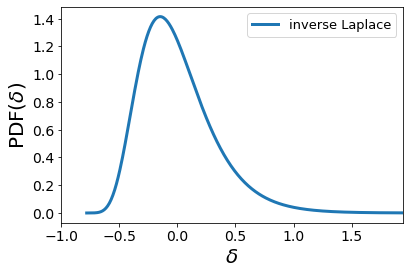

In [6]:
plt.plot(delta_values, PDF_values, linewidth=3, linestyle='solid', label='inverse Laplace')


plt.legend(fontsize=13, loc='upper right')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
var = np.sum(delta_values**2*PDF_values)/np.sum(PDF_values)
plt.xlim(-1.0, 6.0*np.sqrt(var))

plt.xlabel(r'$\delta$', size = 20)
plt.ylabel(r'$\mathrm{PDF}(\delta)$', size = 20)
plt.subplots_adjust(left  = 0.18, right = 0.97, bottom=0.17, top=0.92)

In [7]:
# bias_model = 0: Eulerian
# bias_model = 1: Lagrangian
add_3D_galaxy_sample = lib.add_3D_galaxy_sample
# add_3D_galaxy_sample          (int index_of_universe,        double z, double density_in_Mpc_over_h_cubed,        double b1,        double b2,       double a0,       double a1,   bias_model)
add_3D_galaxy_sample.argtypes = [         ctypes.c_int, ctypes.c_double,                    ctypes.c_double,  ctypes.c_double,  ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_int]
add_3D_galaxy_sample.restype = None


change_parameters_of_3D_galaxy_sample = lib.change_parameters_of_3D_galaxy_sample
# change_parameters_of_3D_galaxy_sample          (int index_of_galaxy_sample,        double z, double density_in_Mpc_over_h_cubed,        double b1,        double b2,       double a0,       double a1,   bias_model)
change_parameters_of_3D_galaxy_sample.argtypes = [              ctypes.c_int, ctypes.c_double,                    ctypes.c_double,  ctypes.c_double,  ctypes.c_double, ctypes.c_double, ctypes.c_double, ctypes.c_int]
change_parameters_of_3D_galaxy_sample.restype = None

# Creating a galaxy sample
bias_model = 0
density_sample_1 = 0.002
b1_sample_1 = 1.6
b2_sample_1 = 0.0
a0 = 1.26
a1 = 0.29
add_3D_galaxy_sample(0, z, density_sample_1, b1_sample_1, b2_sample_1, a0, a1, bias_model)
# Changing parameters first galaxy sample
density_sample_1 = 0.001
change_parameters_of_3D_galaxy_sample(0, z, density_sample_1, b1_sample_1, b2_sample_1, a0, a1, bias_model)

In [11]:
Nmax=100
N = np.repeat(range(100),len(delta_values))
delta = np.tile(delta_values,Nmax)
npoints = len(delta)

return_P_of_N_given_delta_m = lib.return_P_of_N_given_delta_m
# return_P_of_N_given_delta_m(double* P_of_N_given_delta, double* delta, double* N, double N_bar, int npoints, int index_of_galaxy_sample)
return_P_of_N_given_delta_m.argtypes = [ctypes.POINTER(ctypes.c_double*npoints), ctypes.POINTER(ctypes.c_double*npoints), ctypes.POINTER(ctypes.c_double*npoints), ctypes.c_double, ctypes.c_int, ctypes.c_int]
return_P_of_N_given_delta_m.restype = None


In [14]:
len(delta)

6000000